### Model 1: Topic Modeling : Latent Dirichlet Allocation(LDA)

In [126]:
#import required libraries
import re
import nltk
import pandas as pd
from num2words import num2words
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import defaultdict, Counter
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/suvarnaaglave/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [127]:
#load data
file_path = 'BA_Airline_NegativeReviews_Half.csv'
df = pd.read_csv(file_path)

df1=df.copy()

# Tokenization already done: df['tokens']
df1['tokens'] = df['ReviewBody'].apply(lambda x: x.split())

nltk_stopwords = set(stopwords.words('english'))

#define custom stopwords to remove (lowercase for matching)
custom_stopwords = {'u', 'us', 'could', 'would', 'ba', 'british', 'airways', 'flight', 'airline', 'hour', 'and'}  
all_stopwords = nltk_stopwords.union(custom_stopwords)

#remove these stopwords from the token list
df1['tokens'] = df1['tokens'].apply(
    lambda tokens: [token for token in tokens if token.lower() not in all_stopwords and not re.search(r'\d', token)])

# remove numbers from the token list
df1['tokens'] = df1['tokens'].apply(lambda tokens: [re.sub(r'\d+', '', word) for word in tokens if not word.isnumeric()])

#create Dictionary and Corpus
dictionary = corpora.Dictionary(df1['tokens'])
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in df1['tokens']]

#LDA Model
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=12,         # You can tune this number
    random_state=42,
    passes=600,
    alpha='auto',
    eta='auto',
    per_word_topics=True
)

#show topics
topics = lda_model.print_topics(num_words=10)

# Assign topics to each review (with multiple topic probabilities)
df['review_topics'] = [lda_model.get_document_topics(bow) for bow in corpus]

# Display a few examples
print(df[['ReviewBody', 'review_topics']].head())


                                          ReviewBody  \
0  4 Hours takeoff received Mail stating cryptic ...   
1  I recently delay British Airways BRU LHR due s...   
2  5 day flight advised BA cancelled asked u rebo...   
3  We traveled Lisbon dream vacation cruise Portu...   
4  Booked flight Bucharest Manchester 2h 45 layov...   

                                       review_topics  
0  [(1, 0.46431106), (5, 0.12064724), (9, 0.22157...  
1  [(1, 0.1634525), (5, 0.1302675), (9, 0.0948787...  
2                                  [(6, 0.99399436)]  
3                  [(0, 0.4220531), (9, 0.56979007)]  
4  [(0, 0.33126116), (1, 0.45511433), (10, 0.2081...  


In [128]:
#prepare the visualization
lda_vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

#display in a notebook (if using Jupyter)
pyLDAvis.display(lda_vis_data)

#save to HTML to run outside notebook
pyLDAvis.save_html(lda_vis_data, 'BA_Airline_LDA_Visualization.html')

print("LDA topic visualization saved to: BA_Airline_LDA_Visualization.html")


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=1004) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=1004) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=1004) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=1004) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: T

LDA topic visualization saved to: BA_Airline_LDA_Visualization.html


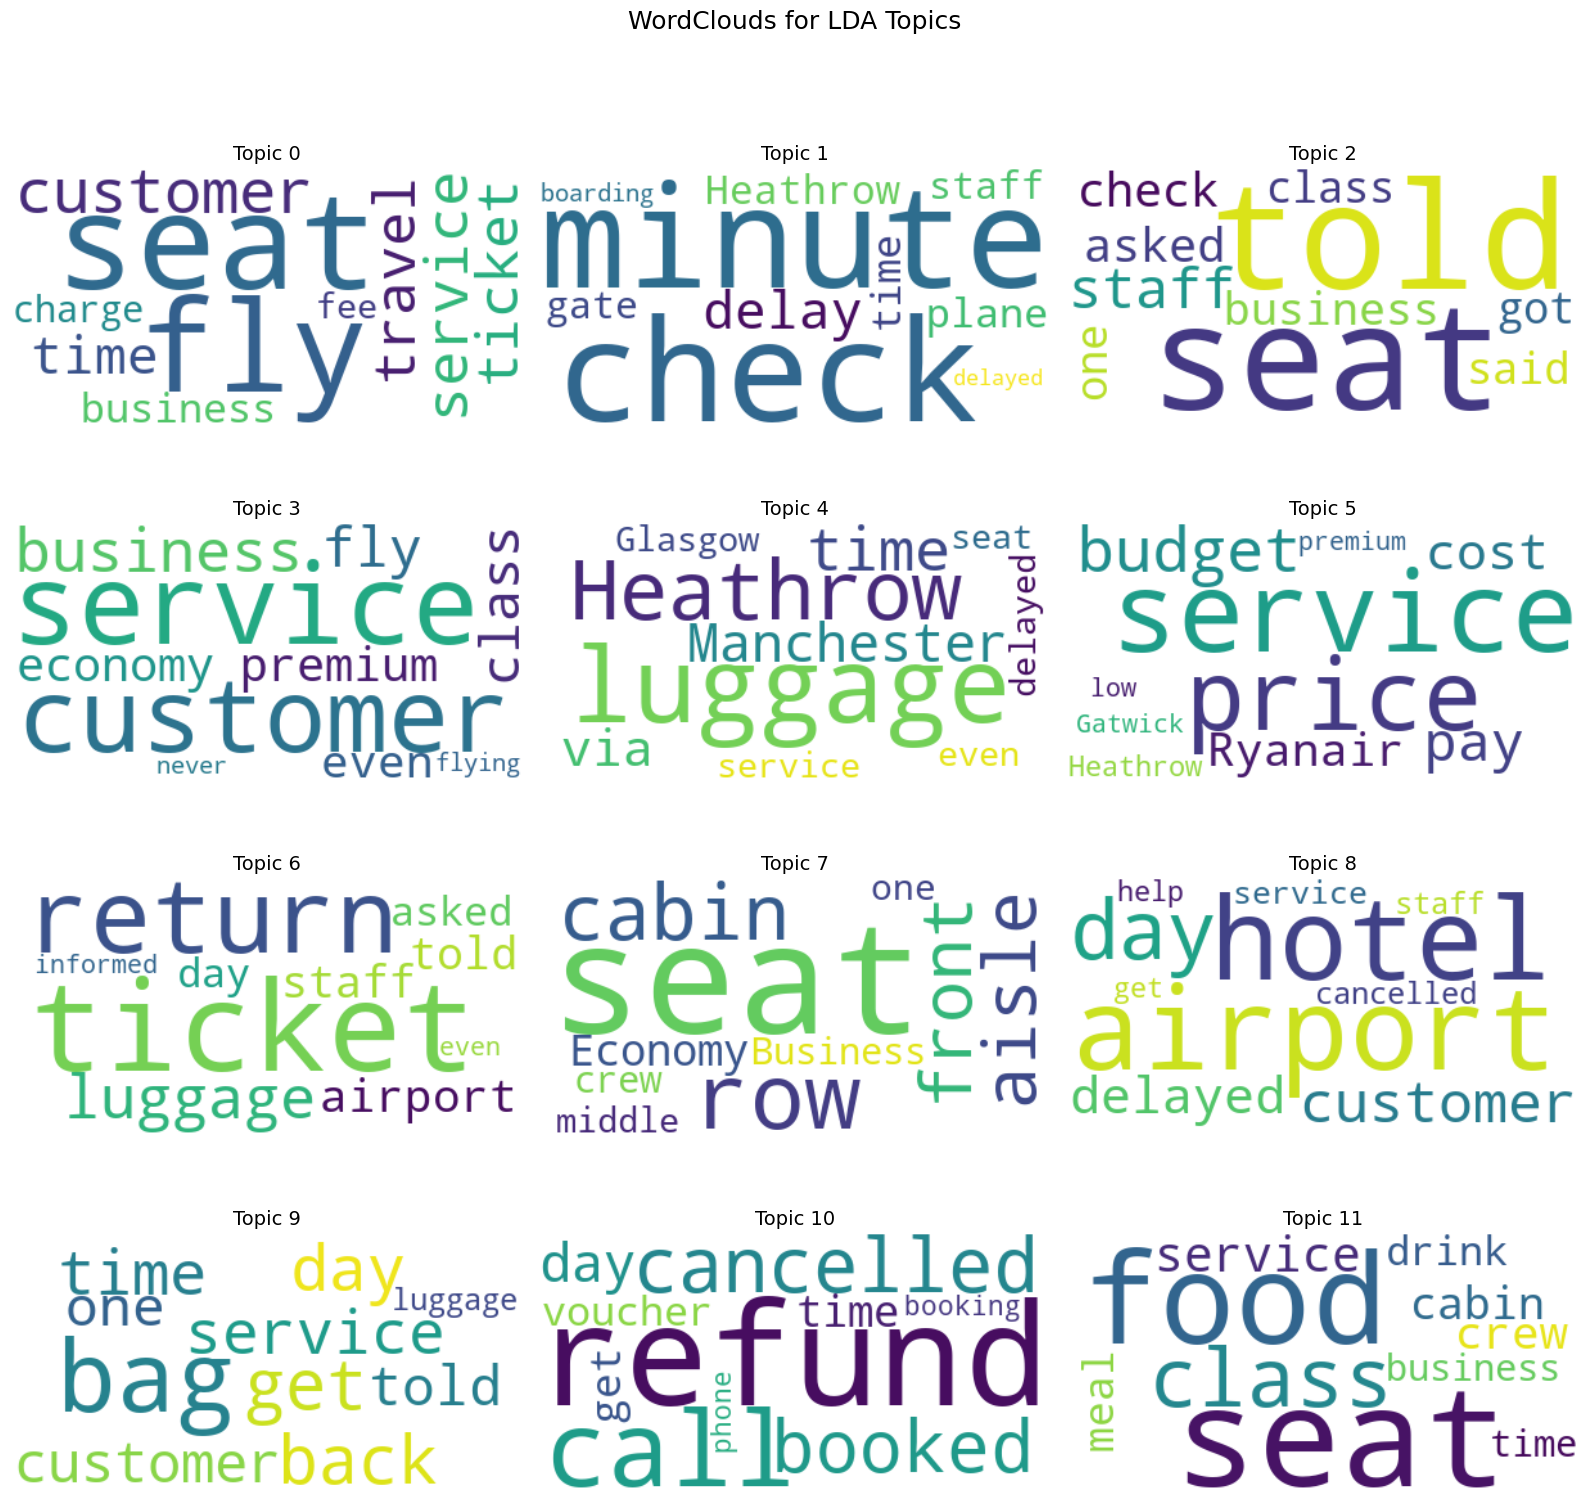

In [129]:
#create wordclouds for each topic
def plot_topic_wordclouds(lda_model, num_topics, num_words=10):
    cols = 3
    rows = (num_topics + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows), squeeze=False)
    fig.suptitle("WordClouds for LDA Topics", fontsize=18)

    for topic_id in range(num_topics):
        topic_words = dict(lda_model.show_topic(topic_id, topn=num_words))
        wordcloud = WordCloud(background_color='white', colormap='viridis').generate_from_frequencies(topic_words)

        row, col = divmod(topic_id, cols)
        ax = axes[row][col]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f"Topic {topic_id}", fontsize=14)
        ax.axis('off')

    # Hide empty subplots
    for i in range(num_topics, rows * cols):
        row, col = divmod(i, cols)
        axes[row][col].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

#call the function
plot_topic_wordclouds(lda_model, num_topics=12)


In [130]:
# 1.define keywords for each category
category_keywords = {

    'Food and Beverage': [
        'food', 'bad', 'inedible', 'catering', 'tiny', 'bottle', 'water', 'snack', 'offered', 'poor', 'meal', 'service', 'goodies',
        'drinks', 'half', 'cup', 'tasteless', 'stale', 'snacks', 'quality', 'limited', 'options', 'ran', 'out', 'cold', 'bland', 'hungry',
        'unappetizing', 'expired', 'items', 'served', 'vegetarian', 'smell', 'provided', 'beverages', 'tray', 'portion', 
        'size', 'small', 'dietary', 'needs', 'ignored', 'spoiled', 'burnt', 'eat', 'low', 'ingredients', 'really', 'refreshment', 
        'choice', 'drink', 'snack', 'beverage', 'catering', 'coffee', 'breakfast', 'eggs', 'scrambled', 'beef', 'smashed', 'potatoes',
        'chocolate', 'bar', 'biscuits', 'basic'
    ],
    'Booking & Check-in Issues': [
        'check-in', 'problem', 'boarding', 'pass', 'error', 'reservation', 'ticket', 'valid', 'denied', 'booking', 'couldn’t', 'rest',
        'online', 'confirmed', 'long', 'queue', 'assigned', 'confusing', 'process', 'system', 'glitch', 'website', 'kept', 'booked',
        'crashing', 'mobile', 'app', 'failed', 'name', 'mismatch', 'duplicate', 'wrong', 'travel', 'dates', 'status', 'agent', 'mistake', 
        'counters', 'closed', 'early', 'printed', 'accepted', 'checkin', 'confirmation', 'waiting', 'stand', 'deal', 'book', 'wait',
        'another', 'refused', 'rebooking', 'online', 'standing', 'atrocious', 'Website', 'difficult', 'navigate', 'board', 'retraction',
        'chaos', 'reinstated', 'standby', 'allocated', 'allocation', 'slow', 'organised', 'Chaos', 'management', 'destination', 'COVID',
        'struggling', 'communication', 'email', 'overcrowded', 'crashed', 'computer', 'crowd', 'procedure', 'queue', 'disorganised', 
        'impatient', 'crowded', 'replacement', 'electronically', 'unavailable', 'unavailability', 'unusable', 'desk', 'rebooked', 'rebook',
        'gate', 'load', 'line', 'huge', 'outdated'
    ],
    'Seating Comfort': [
        'tight', 'legroom', 'seat', 'uncomfortable', 'seats', 'cramped', 'poor', 'design', 'reclining', 'doesn’t', 'recline', 'leg', 'room', 
        'legs', 'broken', 'wouldn’t', 'area', 'old', 'worn', 'crowded', 'cabin', 'configuration', 'armrest', 'cushion', 'flat', 'crammed',
        'back', 'support', 'missing', 'aisle', 'exposed', 'tray', 'table', 'felt', 'seatbelt', 'tight', 'overhead', 'bin', 'above', 'match', 
        'footrest', 'hard', 'sleep', 'movement', 'seating', 'reclined', 'comfort', 'torn', 'cracked', 'jostling', 'sat', 'limited', 'Seats',
        'stretch', 'middle', 'centre', 'narrow', 'squeezed', 'gap', 'space', 'window', 'button', 'spasm', 'knee', 'padding', 'stowage', 'poor',
        'design', 'cubicle', 'comfy', 'comfortable', 'Recline', 'pushed', 'arm', 'blocked', 'tilted'
    ],
    'In-Flight Experience Issues': [
        'inflight', 'entertainment', 'broken', 'screen', 'WiFi', 'working', 'USB', 'port', 'failed', 'unavailable', 'headphone',
        'provided', 'noisy', 'couldn’t', 'access', 'shop', 'system', 'loud', 'cabin', 'noise', 'unclean', 'restrooms',  
        'lighting', 'bad', 'smell', 'annoying', 'addressed', 'temperature', 'boring', 'reading', 'materials', 'wifi',
        'air', 'conditioning', 'didn’t', 'work', 'dark', 'day', 'overhead', 'lights', 'respond', 'call', 'button', 'bed',
        'toilet', 'ran', 'supplies', 'felt', 'stuffy', 'announcements', 'window', 'shade', 'magazines', 'missing', 'blankets', 'pillows', 
        'space', 'dirty', 'wifi', 'IFE', 'movie', 'movies', 'selection', 'noise', 'temperature', 'cabin', 'IFE', 'headphones', 
        'pillow', 'blanket', 'attendant', 'AC', 'disturb', 'crying', 'baby', 'shouting', 'facility', 'medium', 'poor', 'charge',
        'point', 'welcome', 'package', 'disrupt', 'disrupted', 'cabin', 'power', 'supply', 'table', 'grabbing', 'tracker',
        'failure', 'joke', 'condition', 'electronics', 'functional', 'blocking', 'coach', 'place', 'comfortably', 'store', 'item', 'holder',
        'entire', 'control', 'size', 'position', 'haul', 'trip', 'touch', 'charger', 'magazine', 'shop', 'old', 'plane', 'filthy', 'brush',
        'tooth brush', 'earplugs', 'socks', 'disposable', 'outlet', 'internet', 'traffic', 'pilot', 'TV', 'Tv', 'tablet', 'function',
        'exception'
    ],
    'Baggage Problems': [
        'lost', 'luggage', 'baggage', 'arrived', 'got', 'bag', 'mishandled', 'information', 'hand', 'taken', 'missing', 'Missing', 'suitcase',
        'unclear', 'damaged', 'mishandled', 'bags', 'extra', 'charges', 'tampered', 'claim', 'took', 'long', 'items', 'tags', 'Bags',
        'opened', 'transit', 'received', 'someone', 'else', 'arrived', 'next', 'day', 'tracking', 'available', 'report', 'airport', 'Lost',
        'line', 'chaotic', 'refused', 'help', 'handle', 'broken', 'denied', 'carry', 'cabin', 'overhead', 'limits', 'avoid', 'waiting', 
        'pay', 'hour', 'reclaim', 'claim', 'delay', 'personal', 'belonging', 'checked', 'little', 'effort', 'wife', 'reclaim', 'airtags',
        'carryon', 'mistagged', 'tag', 'tags', 'promised', 'discovered', 'destroyed', 'figure', 'handling', 'left', 'behind', 'locate', 
        'wheel', 'reported', 'showed', 'trolley', 'mislabelled', 'clothes', 'jewellery', 'Luggage', 'Baggage', 'reconcile', 'collect', 
        'space', 'damaged', 'loaded', 'pram', 'stroller', 'counter', 'zip', 'carousel', 'priority'
    ],
    'Flight Delays & Cancellations': [
        'delayed', 'missed', 'connection', 'cancelled', 'notice', 'delay', 'reason', 'rescheduled', 'stuck', 'plane', 'departure',
        'waited', 'hours', 'long', 'late', 'last-minute', 'left', 'poor', 'communication', 'connecting', 'multiple', 'alternate',
        'provided', 'weather', 'used', 'excuse', 'arrived', 'causing', 'communicated', 'work', 'tight', 'excuse', 'changed',
        'tarmac', 'technical', 'fault', 'early', 'morning', 'hotel', 'minute', 'return', 'cancellation', 'Delayed', 'arrival', 'reschedule', 
        'cancel', 'rescheduled', 'covid', 'covid19', 'excuse', 'wait', 'takeoff', 'holding', 'late', 'hour', 'departed', 'return',
        'miss', 'cancellation', 'expected', 'minute', 'canceled', 'replacement', 'arrived', 'Cancelled', 'connecting', 'explanation',  
        'aircraft', 'zero', 'dismissive', 'returned', 'fault', 'original', 'estimated', 'extended', 'additional', 'inbound',
        'unexpectedly', 'unexpected', 'clearly', 'dismissive', 'unfortunately', 'notifying', 'schedule', 'scheduled', 'terrible', 'several', 
        'morning', 'already', 'always', 'apologized', 'acceptable', 'cancel'
    ],
    'Refund & Compensation Disputes': [
        'refund', 'waiting', 'compensation', 'denied', 'insufficient', 'claim', 'rejected', 'asked', 'money', 'returned', 'penny', 'compensate',
        'reimbursement', 'issue', 'refused', 'pay', 'filed', 'received', 'policy', 'excessive', 'cancellation', 'fee', 'response', 'support',
        'delayed', 'ineligible', 'request', 'chase', 'weeks', 'misleading', 'terms', 'submission', 'worked', 'follow-up', 'airline', 'dispute',
        'explained', 'clearly', 'called', 'multiple', 'times', 'result', 'agent', 'eligible', 'reason', 'processing', 'deducted', 'partial',
        'only', 'reimburse', 'missed', 'connection', 'unfair', 'denial', 'automated', 'system', 'updates', 'refused', 'claimed', 'excuse',
        'reimbursed', 'offered', 'claimed', 'received', 'expense', 'penalty', 'followup', 'refunded', 'refundable', 'multiple', 'call', 'full',
        'partially', 'financial', 'cooling', 'possibility', 'rejection', 'alternative'
    ],
    'Loyalty Program and benefits': [
        'Avios', 'devalued', 'elite', 'member', 'upgraded', 'lounge', 'loyalty', 'recognition', 'membership', 'perks', 'lose', 'expect',
        'ignored', 'tier', 'status', 'upgrade', 'program', 'points', 'credited', 'recognized', 'benefits', 'confusing', 'reward', 'system',
        'expire', 'unfairly', 'downgraded', 'reason', 'frequent', 'flyer', 'support', 'useless', 'transparency', 'situation', 'privilege',
        'tiers', 'priority', 'access', 'earned', 'miles', 'vanished', 'partner', 'airline', 'honor', 'advertised', 'email', 'downgrade',
        'response', 'team', 'website', 'show', 'updated', 'difficult', 'redeem', 'rewards', 'account', 'blocked', 'number', 'accepted', 
        'offer',  'avios', 'voucher', 'benefit', 'e-voucher', 'coupon', 'loyal', 'difference', 'business', 'class', 'economy', 'premium',
        'accountability', 'accommodation', 'discount', 'unfair', 'customer', 'room', 'efficiency', 'decency', 'shuttle', 'bus', 'companion',
        'message', 'opted', 'credit', 'credits', 'applying', 'future', 'change', 'hotline', 'sufficient', 'adjust', 'adjusting', 'flexible'
    ],
    'Overpriced & Poor Value for Money': [
        'worth', 'price', 'overpriced', 'ticket', 'expensive', 'service', 'ripoff', 'charged', 'more', 'value', 'money', 'quality', 'hidden',
        'fees', 'everywhere', 'rip-off', 'felt', 'cheated', 'low', 'fare', 'waste', 'business', 'class', 'economy',
        'downgrade', 'trap', 'charged', 'extra',  'included', 'high', 'costs', 'budget', 'forced', 'last', 'step', 'paid', 'competitors', 
        'worse', 'scam', 'pricing', 'tactics', 'charge', 'cost', 'pound', 'euro'
    ],
    'Accessibility and special assistance': [
        'wheelchair', 'help', 'assistance', 'service', 'poor', 'denied', 'special', 'needed', 'disabled', 'access', 'boarding', 
        'provided', 'ignored', 'lack', 'features', 'elderly', 'passengers', 'staff', 'untrained', 'needs', 'rude', 'support', 'inaccessible',
        'restroom', 'visual', 'announcements', 'escort', 'showed', 'rushed', 'despite', 'disability', 'request', 'system', 'empathy', 
        'forced', 'walk', 'distance', 'priority', 'respected', 'desk', 'unmanned', 'heavy', 'mobility', 'gear', 'flagged', 'delivered', 
        'wait', 'vehicle', 'accessibility', 'children', 'unable', 'chair', 'care', 'assist', 'disappointed', 'Denied', 'chairstroller',
        'distress', 'frustration', 'mobile', 'mobility', 'corridor', 'help', 'frustrated', 'nightmare', 'transportation', 'fold', 'Care', 
        'child', 'attention'
    ],
    'Airline Staff & Ground Services': [
        'staff', 'rude', 'service', 'ground', 'crew', 'unhelpful', 'dismissive', 'help', 'desk', 'attitude', 'helpline', 'reply', 'bullying',
        'unprofessional', 'behavior', 'understaffed', 'callousness', 'ignored', 'complaints', 'disorganized', 'empathise', 'seemed', 'annoyed',
        'communication', 'elderly', 'laughed', 'complaint', 'agent', 'check', 'document', 'properly', 'customer care', 'misleading', 'frustrating',
        'repeated', 'requests', 'rushed', 'threatened', 'remove', 'helpdesk', 'hours', 'blamed', 'system', 'error', 'level', 'embarrassing',
        'worse', 'worst', 'nightmare', 'disgrace', 'get', 'nonexistent', 'disrespect', 'respect', 'disappeared', 'laughing', 'rude', 
        'attendant', 'employee', 'Staff', 'shortage', 'managed', 'poorly', 'unaware', 'mediocre', 'clueless', 'cleaning', 'unprofessional',
        'bother', 'callous', 'disregard', 'brunt', 'complaint', 'uncaring', 'trained', 'budge', 'argumentative', 'accusatory', 'mediocrity',
        'unsympathetic', 'solve', 'problem', 'cruelty', 'miserable', 'ugly', 'predicament', 'terrible', 'inattentive', 'appalled', 'appaling',
        'incompetent', 'untrustworthy', 'aggressive', 'obnoxious', 'impatient', 'flippant', 'disgusting', 'disappointing', 'abusive', 'arrogant',
        'unapologetic', 'empathize'
    ],
    'Safety & Security Concerns': [
        'unsafe', 'safety', 'briefing', 'exit', 'row', 'concern', 'check', 'seatbelts', 'security', 'ignored', 'passenger', 
        'aggressive', 'felt', 'equipment', 'faulty', 'seatbelt', 'broken', 'misconduct', 'cockpit', 'door', 'left', 'open', 
        'emergency', 'exits', 'blocked', 'lights', 'work', 'pilot', 'announcement', 'unclear', 'dismissed', 'serious', 'behavior', 
        'reported', 'cabin', 'takeoff', 'evacuation', 'procedure', 'shown', 'stand', 'landing', 'aircraft', 'maintained', 'officer', 
        'absent', 'overhead', 'bin', 'popped', 'incident', 'turbulence', 'horrible', 'experience', 'abuse', 'indication',
        'carrier', 'slammed', 'stranded', 'foreign', 'engine', 'stress', 'heart', 'attack', 'risk', 'hernia', 'sign', 'stopped',
        'evacuated', 'knee', 'suffered', 'medical', 'contempt', 'ineptitude', 'insult', 'injury', 'turmoil', 'weed', 'panicked',
        'horror', 'grotty', 'trapped', 'horrendous', 'secure', 'asthma', 'disappointment', 'family', 'turbulent', 'insecurity',
        'mask', 'facial', 'stressful', 'protocol', 'social', 'safe', 'pandemic', 'threatened', 'awful', 'furious', 'frustrated'   
    ]
}

# 2.reverse map: word → category
word_to_category = {}
for cat, words in category_keywords.items():
    for w in words:
        word_to_category[w] = cat

# 3.get LDA topics and map to categories
topic_labels = {}
topics = lda_model.show_topics(num_topics=12, num_words=10, formatted=False)

for topic_id, topic_words in topics:
    category_count = Counter()
    for word, _ in topic_words:
        matched_cat = word_to_category.get(word.lower())
        if matched_cat:
            category_count[matched_cat] += 1

    #assign the category with most keyword matches (or 'Unknown')
    best_match = category_count.most_common(1)
    topic_labels[topic_id] = best_match[0][0] if best_match else "Unknown"

# 4.apply labels to reviews based on multiple topics
def get_topk_topic_labels(topic_probs, topic_labels, k=5):
    # Sort by probability descending and select top-k topic IDs
    topk_topics = sorted(topic_probs, key=lambda x: x[1], reverse=True)[:k]
    labels = {topic_labels.get(topic_id, "Unknown") for topic_id, _ in topk_topics}
    return list(labels)

#apply multi-label assignment
df['review_topics'] = df['review_topics'].apply(lambda x: get_topk_topic_labels(x, topic_labels, k=5))


In [131]:
df['review_topics']

0       [Overpriced & Poor Value for Money, Flight Del...
1       [Overpriced & Poor Value for Money, Baggage Pr...
2                                      [Baggage Problems]
3       [Overpriced & Poor Value for Money, Baggage Pr...
4       [Overpriced & Poor Value for Money, Flight Del...
                              ...                        
1097                [Food and Beverage, Baggage Problems]
1098    [Food and Beverage, Refund & Compensation Disp...
1099    [Food and Beverage, Flight Delays & Cancellati...
1100    [Overpriced & Poor Value for Money, Food and B...
1101    [Refund & Compensation Disputes, Airline Staff...
Name: review_topics, Length: 1102, dtype: object

In [132]:
#save results
df.to_csv('BA_Airline_NegativeReviews_with_LDA.csv', index=False)

In [133]:
coherence_model_lda = CoherenceModel(
    model=lda_model,
    texts=df1['tokens'],      #list of tokenized review texts
    dictionary=dictionary,
    coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()
print(f"Coherence Score (C_v): {coherence_lda:.4f}")


Coherence Score (C_v): 0.3859


In [134]:
# extract top words from each topic
top_words = []
for topic_id, topic_words in topics:
    words = [word for word, _ in topic_words]
    top_words.extend(words)

unique_words = set(top_words)
total_words = len(top_words)
topic_diversity = len(unique_words) / total_words

print(f"Topic Diversity: {topic_diversity:.4f}")


Topic Diversity: 0.5667


In [135]:
def compute_coherence_and_diversity(dictionary, corpus, texts, start=5, limit=21, step=1, topn_words=10):

    coherence_scores = []
    diversity_scores = []
    topic_range = range(start, limit, step)

    for num_topics in topic_range:
        
        lda_model = LdaModel(corpus=corpus,
                             id2word=dictionary,
                             num_topics=num_topics,
                             random_state=42,
                             passes=600,
                             alpha='auto',
                             eta='auto',
                             per_word_topics=True)
        

        # Coherence Score
        coherence_model = CoherenceModel(model=lda_model,
                                         texts=texts,
                                         dictionary=dictionary,
                                         coherence='c_v')
        coherence = coherence_model.get_coherence()
        coherence_scores.append(coherence)

        # Topic Diversity
        topics = lda_model.show_topics(num_topics=num_topics, num_words=topn_words, formatted=False)
        all_words = [word for topic in topics for word, _ in topic[1]]
        unique_words = set(all_words)
        diversity = len(unique_words) / len(all_words)
        diversity_scores.append(diversity)

        print(f"Topics: {num_topics}, Coherence: {coherence:.4f}, Diversity: {diversity:.4f}")

    return topic_range, coherence_scores, diversity_scores


Topics: 11, Coherence: 0.3824, Diversity: 0.5273
Topics: 12, Coherence: 0.3859, Diversity: 0.5667
Topics: 13, Coherence: 0.3328, Diversity: 0.5923
Topics: 14, Coherence: 0.3618, Diversity: 0.5857


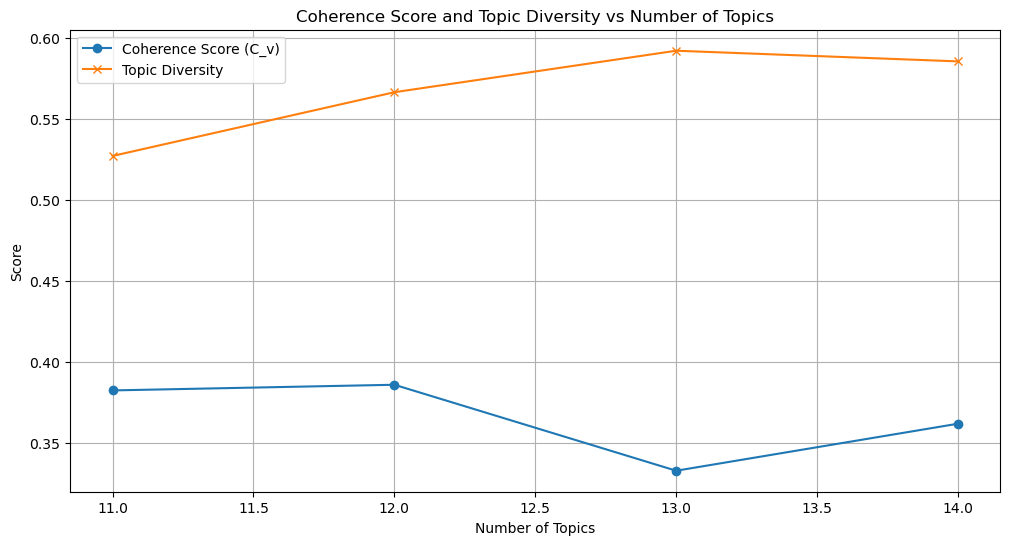

In [136]:
# Run for topic range 5–20
x, coherence_vals, diversity_vals = compute_coherence_and_diversity(dictionary, corpus, df1['tokens'], start=11, limit=15, step=1)

plt.figure(figsize=(12, 6))
plt.plot(x, coherence_vals, marker='o', label='Coherence Score (C_v)')
plt.plot(x, diversity_vals, marker='x', label='Topic Diversity')
plt.title('Coherence Score and Topic Diversity vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()